In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
nl = 64
ng = nl**2 

In [3]:
# CAN for simpletons

In [4]:
class CanCan:
    # Can based on OG paper
    def __init__(self, nl):
        self.nl = nl
        
        # neural sheet belongs to model >:)
        self.sheet = self.create_sheet(nl)
        
        self.tau = 1e-2
        self.dt = 5e-4
        self.tc = self.dt/self.tau # time constant ;) 
        
        self.alpha = 0.10315
        self.l = 2 # I think
    
        # these are excellent parameters, apparently
        lambda_net = 13 # periodicity of the formed lattice
        self.beta = 3/lambda_net**2 
        self.gamma = 1.05*self.beta
        
        self.shift = self.init_shifts()
        self.wr = self.init_periodic_recurrent_weights(self.sheet) # (nl, nl)
        self.win = self.init_input_weights(self.sheet) # (nl, 2)
        
        
        
    def create_sheet(self, nl):
        # create square neural sheet
        x = np.arange(nl) - nl/2
        y = np.arange(nl) - nl/2 
        xx, yy = np.meshgrid(x, y)
        return np.stack((xx, yy), axis = -1)       
        
    def relu(self, x):
        return x*(x > 0.0)
    
    def init_periodic_recurrent_weights(self, sheet):
        
        ravel_sheet = np.reshape(sheet, (-1, 2)) # (64, 64, 2) -> (64**2, 2)
        ravel_shift = np.reshape(self.shift, (-1, 2)) # 
        # compute distances
        d = np.abs(ravel_sheet[:, None] - (ravel_sheet + self.l*ravel_shift)[None])
        # compute periodic distances
        periodic_d = np.minimum(d, self.nl - d) # nl is width of box        
        
        papa = np.sum(periodic_d**2, axis = -1) # ran out of names
        w0 = np.exp(-self.gamma*papa) - np.exp(-self.beta*papa) # DoG
        return w0.reshape((self.nl**2, self.nl**2))
        
    def init_input_weights(self, sheet):
        pass
    
    def init_shifts(self):
        # shifts are north, south, east and west
        # modify mod2 approach to get each cardinal direction
        p = self.sheet[...,0]
        q = self.sheet[...,1]

        a = (p+1)%2*(-1)**q
        b = p%2*(-1)**q

        shift = np.stack((a,b), axis=-1)
        return shift
        
    
    def g(self, r, f = 1, orientation_offset = 0):
        # grid cell func, not strictly needed
        g = 0
        theta = np.arange(3)*np.pi/3 + orientation_offset
        k = np.stack((np.cos(theta), np.sin(theta)), axis = -1)
        g = np.sum(np.cos(2*np.pi*f*np.sum(k[None, None]*r[:,:,None], axis = -1)), axis = -1) # eww
        return g
    
    def forward(self, h, v):
        # h.shape = (nl, nl)
        # v.shape = (2,)
        recurrence = np.tensordot(h, self.wr, axes = (-1, -1))
        velocity_inputs = 1 + self.alpha*np.tensordot(v, self.shift, axes = (-1, -1))
        velocity_inputs = np.ravel(velocity_inputs)
        
        recurrence = self.wr@h
        velocity_inputs = np.ravel(1 + self.alpha*self.shift@v)
        # continuous time rnn
        u = h + self.tc*(self.relu(recurrence + velocity_inputs) - h)
        return u
        


In [5]:
model = CanCan(nl)

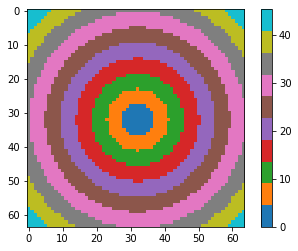

In [6]:
# plot norm of neural sheet coordinates
plt.imshow(np.linalg.norm(model.sheet, axis = -1), cmap = "tab10") # completely uninformative cmap
plt.colorbar()

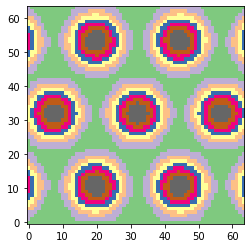

In [7]:
# plot example grid cell function for some reason
g = model.g(model.sheet/nl, f = 3)
plt.imshow(g.T, origin = "lower", cmap = "Accent") # :o)

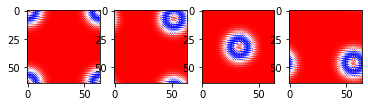

In [8]:
w = model.init_periodic_recurrent_weights(model.sheet)

show_cells = [0, 500, 2080,  3000]
fig, axs = plt.subplots(1, len(show_cells))

for i, cell in enumerate(show_cells):
    axs[i].imshow(w[cell].reshape((nl, nl)), cmap = "bwr")
plt.show()

In [9]:
y = model.init_shifts()

In [10]:
# print some units for sanity
for i in range(4):
    for j in range(4):
        print(y[i,j], end = "")
    print('\n')

[1. 0.][0. 1.][1. 0.][0. 1.]

[-1. -0.][-0. -1.][-1. -0.][-0. -1.]

[1. 0.][0. 1.][1. 0.][0. 1.]

[-1. -0.][-0. -1.][-1. -0.][-0. -1.]



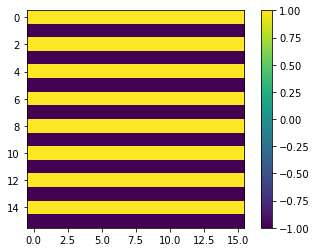

In [11]:
# plot sum of shifts along last axis (should be +1 or -1)
plt.imshow(np.sum(y[:16,:16],axis=-1))
plt.colorbar();

In [12]:
init_state = np.random.uniform(0, 1, (64, 64))
h = np.ravel(init_state)

v = np.array([0,1])*0
model.l = 0 # "if l, alpha =0, the network develops a static triangular grid" 

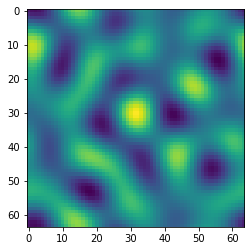

In [16]:
for i in range(100):
    h = model.forward(h, v)
plt.imshow(h.reshape((64, 64)))
plt.show()